In [1]:
import sys
print(sys.version, sys.executable)
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from datetime import date
from collections import Counter
import re
import string
import os
import praw
import nltk
from nltk.corpus import stopwords
from draftfast import rules
from draftfast.optimize import run
from draftfast.orm import Player
from draftfast.csv_parse import salary_download
from draftfast.settings import OptimizerSettings, CustomRule, PlayerPoolSettings
from draftfast.lineup_constraints import LineupConstraints
from draftfast.csv_parse import salary_download

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

ACTIVE_FILE = './data/active.csv'
REDDIT_PW = os.getenv('RED_PW')
CLIENT_SECRET ='CTtsLidvlHgYMhT4IsBW6Dc-2N8'
CLIENT_ID='QH_iPhx9pfhRPQ'
# print(REDDIT_PW)
# SUBREDDIT = 'cryptocurrency' # 'wallstreetbets' # 
SUBREDDIT = 'fantasyfootball'
print('ready')

3.7.12 (default, Oct 13 2021, 06:53:03) 
[Clang 13.0.0 (clang-1300.0.29.3)] /usr/local/opt/python@3.7/bin/python3.7
ready


In [2]:
players = salary_download.generate_players_from_csvs(salary_file_location=ACTIVE_FILE, game=rules.FAN_DUEL)

In [3]:
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent="my user agent")

In [4]:
def filter_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def get_last_name(p):
    return filter_punctuation(p.name.split(' ')[-1]).lower()

print(players[0].name, " --- ", get_last_name(players[0]))

Cooper Kupp  ---  kupp


In [5]:
player_names = [get_last_name(p) for p in players if p.pos != 'D']
print(player_names[:5])
len(player_names)

['kupp', 'henry', 'allen', 'adams', 'samuel']


69

In [6]:
def find_players(text, names, count_duplicates=False):
#     https://stackoverflow.com/questions/48025016/regular-expression-matching-stock-ticker?rq=1
    text = filter_punctuation(text)
    words = text.lower().split()
    names = [w for w in words if w in names]
    return Counter(names) if count_duplicates else Counter(set(names))

find_players('Kupp and Samuel are the best this week', player_names)

Counter({'kupp': 1, 'samuel': 1})

In [7]:
SUBMISSION_LIMIT = 20
submissions = reddit.subreddit(SUBREDDIT).hot(limit=SUBMISSION_LIMIT)
submissions = list(submissions)

In [8]:
for s in submissions[:10]:
    print(s.title)
    
print(len(submissions))

Official: [Index] - Sat Morning, 01/22/2022
[Rapoport] #Titans RB Derrick Henry will play today with a metal plate and 5 screws in his foot and a metal plate in his shoe. My story on the return of the 👑
The Titans have officially activated RB Derrick Henry. He’s back.
Who are some 2022 Rookies you’re considering to draft next year?
Looking across nearly 3000 leagues, which players gave you the best odds at a championship this year? Who should you have drafted and who should you have traded for? Includes a widget to look up the odds of 178 different players.
Jerry Jones is frustrated with Amari Cooper's contract and relative production.
Cam Akers and Sony Michel 1-2 punch next season? Where does Henderson sit?
FanDuel NFL Wild Card Saturday DFS Lineup Advice (1/15)
The Rams designated RB Darrell Henderson Jr. to return from IR.
Looking to create custom logos for their team.
20


In [9]:
cnt = Counter()
COMMENT_LEVELS = 5

for i, submission in enumerate(submissions):
    print('\n',i+1,submission.title)
    submission.comments.replace_more(limit=COMMENT_LEVELS) #limit=None (keeps all subtrees of comments, 0 ignores)
    submission.comment_sort = "top" # one of (confidence, top, new, controversial, old, random, qa, live, blank)
    comments = submission.comments.list()
    print('comments', len(comments))
    names = Counter()
    for comment in comments:
        text = comment.body or ''
        names += find_players(text, player_names)
        # print('text preview: ', text[:100])
    print('names', names)
    cnt += names


 1 Official: [Index] - Sat Morning, 01/22/2022
comments 0
names Counter()

 2 [Rapoport] #Titans RB Derrick Henry will play today with a metal plate and 5 screws in his foot and a metal plate in his shoe. My story on the return of the 👑
comments 11
names Counter({'henry': 1})

 3 The Titans have officially activated RB Derrick Henry. He’s back.
comments 65
names Counter({'henry': 9, 'kupp': 2})

 4 Who are some 2022 Rookies you’re considering to draft next year?
comments 33
names Counter({'chase': 3, 'mitchell': 2, 'love': 1})

 5 Looking across nearly 3000 leagues, which players gave you the best odds at a championship this year? Who should you have drafted and who should you have traded for? Includes a widget to look up the odds of 178 different players.
comments 19
names Counter({'kupp': 2, 'robinson': 1, 'allen': 1, 'brown': 1})

 6 Jerry Jones is frustrated with Amari Cooper's contract and relative production.
comments 154
names Counter({'jones': 4, 'evans': 4, 'love': 3, 'allen'

In [10]:
data = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
x_label = 'name'
data = data.rename(columns={'index': x_label, 0: "count"})
data = data.sort_values(by='count', ascending=False)
data

,name,count
16,michel,35
17,akers,27
0,henry,15
23,burrow,8
4,love,6
19,singletary,5
15,rodgers,5
14,brady,5
1,kupp,5
24,mahomes,5


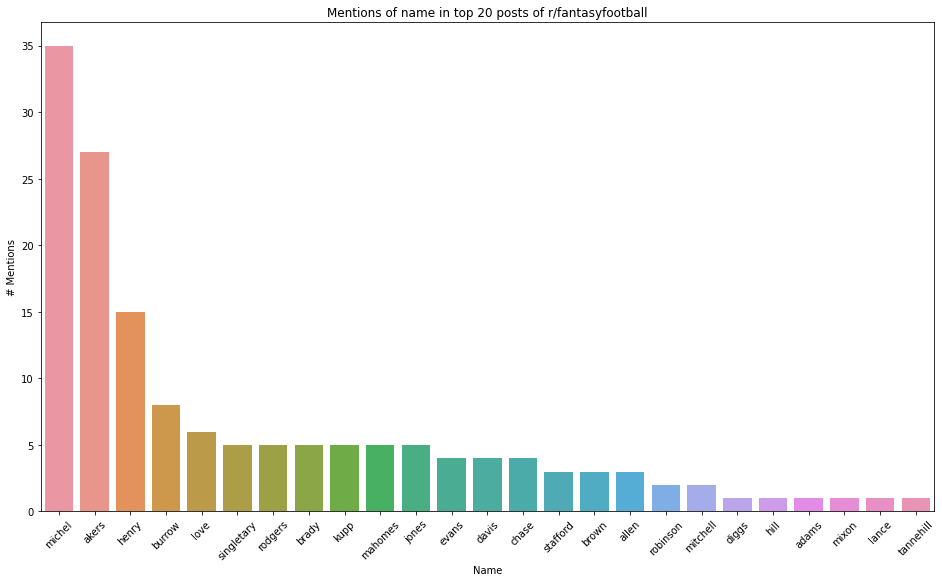

In [11]:
plt.figure(figsize=(16,9))

ax = sns.barplot(x=x_label, y='count',data=data[:25])
plt.xlabel(x_label.capitalize())  
plt.ylabel('# Mentions')  
plt.title(f"Mentions of {x_label} in top {SUBMISSION_LIMIT} posts of r/{SUBREDDIT}")
plt.xticks(rotation = 45)
plt.show()

In [12]:
# TODO: render full name in chart